[[mybinderで開く]](https://mybinder.org/v2/gh/keisukefujii/QulacsExamples/HEAD?filepath=01_how_to_use_qulacs.ipynb) 

# Quantum Circuit Learningを用いた分類

5.2節で学んだ **Quantum Circuit Learning** (量子回路学習、QCL)は機械学習への応用を念頭に設計された量子アルゴリズムである。  
5.2節では入出力ともに1次元の関数を扱ったが、現実の機械学習に応用するためには、より複雑な関数を近似できることが必要である。  

ここではQCLの機械学習への応用例として、代表的な機械学習のデータセットの一つである[Irisデータセット](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)（Fisherのあやめ）の分類を行う。関数の詳細はこのノートブックと同じフォルダに入っている``qcl_prediction.py``にある。

※ このコラムでは、``scikit-learn, pandas``を使用する。

In [2]:
from qcl_classification import QclClassification

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### データの概要

irisデータセットは機械学習でよく使われるアヤメの品種データである。  
花びらやがくの長さ・幅のデータから、3品種のうちどれに属するかを分類する。  
より詳細には[こちらのサイト](https://note.nkmk.me/python-scikit-learn-svm-iris-dataset/)を参照されたい。

まず、scikit-learnから、Irisデータセットを読み込む。  

In [4]:
# Irisデータセットの読み込み

import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()

# 扱いやすいよう、pandasのDataFrame形式に変換
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_names'] = iris.target_names[iris.target]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


ここで、列名の最初の4つ（sepal lengthなど）は、「がく」や花びらの長さ・幅を表しており、target, target_namesはそれぞれ品種番号(0,1,2)、品種名を表している。

In [5]:
# サンプル総数
print(f"# of records: {len(df)}\n")

# 各品種のサンプル数
print("value_counts:")
print(df.target_names.value_counts())

# of records: 150

value_counts:
versicolor    50
setosa        50
virginica     50
Name: target_names, dtype: int64


各サンプルについて、sepal length（がくの長さ）など4種類のデータがあるが、これらのうちpetal length(花びらの長さ), petal width(花びらの幅)に着目して分析を行う。

In [6]:
## 教師データ作成
# ここではpetal length, petal widthの2種類のデータを用いる。より高次元への拡張は容易である。
x_train = df.loc[:,['petal length (cm)', 'petal width (cm)']].to_numpy() # shape:(150, 2)
y_train = np.eye(3)[iris.target] # one-hot 表現 shape:(150, 3)

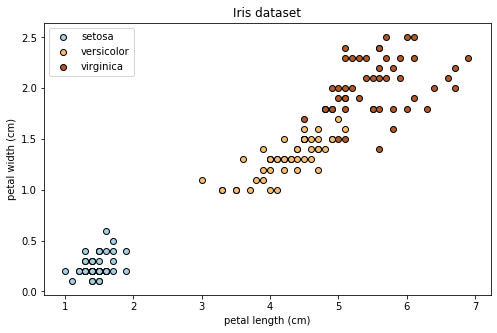

In [7]:
# データ点のプロット
plt.figure(figsize=(8, 5))

for t in range(3):
    x = x_train[iris.target==t][:,0]
    y = x_train[iris.target==t][:,1]
    cm = [plt.cm.Paired([c]) for c in [0,6,11]]
    plt.scatter(x, y, c=cm[t], edgecolors='k', label=iris.target_names[t])

# label
plt.title('Iris dataset')
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)') 
plt.legend()
plt.show()

### QCLを用いた分類

以下ではQCLを用いた分類問題を解くクラスであるQclClassificationを用いて、実際にIrisデータセットが分類される様子を見る。

In [8]:
# 乱数発生器の初期化（量子回路のパラメータの初期値に用いる）
random_seed = 0
np.random.seed(random_seed)

In [30]:
# 量子回路のパラメータ
nqubit = 4 ## qubitの数。必要とする出力の次元数よりも多い必要がある
c_depth = 3 ## circuitの深さ
num_class = 3 ## 分類数（ここでは3つの品種に分類）

In [31]:
# QclClassificationクラスをインスタンス化
qcl = QclClassification(nqubit, c_depth, num_class)

QclClassificationのfit()メソッドで、関数のfittingを行う。  
学習には筆者のPC(CPU:2.3GHz Intel Core i5)で20秒程度を要する。

In [38]:
# 最適化手法BFGS法を用いて学習を行う
import time
start = time.time()
res, theta_init, theta_opt = qcl.fit(x_train, y_train, maxiter=20)
print(f'elapsed time: {time.time() - start:.1f}s')

Initial parameter:
[5.91485056 5.02153795 3.96122121 5.49331331 1.84110075 5.33406967
 3.88223375 0.08316963 2.18173254 0.93079648 6.169016   3.00568928
 3.12520212 4.01792432 2.31588538 0.86016978 5.16551806 1.19284961
 3.21271192 1.40942546 0.61477503 5.41730907 6.11303344 6.03710221
 5.69605619 4.86348283 2.09321272 0.50957506 2.55877174 1.45917015
 0.83244436 0.33569288 4.55904385 0.07180084 4.84170164 0.923293  ]

Initial value of cost function:  0.9986

Iteration count...
Iteration: 2 / 20,   Value of cost_func: 0.8858
Iteration: 4 / 20,   Value of cost_func: 0.7867
Iteration: 6 / 20,   Value of cost_func: 0.7486
Iteration: 8 / 20,   Value of cost_func: 0.7348
Iteration: 10 / 20,   Value of cost_func: 0.7204
Iteration: 12 / 20,   Value of cost_func: 0.7117
Iteration: 14 / 20,   Value of cost_func: 0.7075
Iteration: 16 / 20,   Value of cost_func: 0.6997
Iteration: 18 / 20,   Value of cost_func: 0.6967
Iteration: 20 / 20,   Value of cost_func: 0.6953

Optimized parameter:
[ 6.01025

### プロット

In [39]:
# グラフ用の設定
h = .05  # step size in the mesh
X = x_train
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [40]:
# 各petal length, petal widthについて、モデルの予測値をプロットする関数
def decision_boundary(X, y, theta, title='(title here)'):
    plt.figure(figsize=(8, 5))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    qcl.set_input_state(np.c_[xx.ravel(), yy.ravel()])
    Z = qcl.pred(theta) # モデルのパラメータθも更新される
    Z = np.argmax(Z, axis=1)
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

    # label
    plt.title(title)
    plt.xlabel('petal length (cm)')
    plt.ylabel('petal width (cm)')
    plt.show()

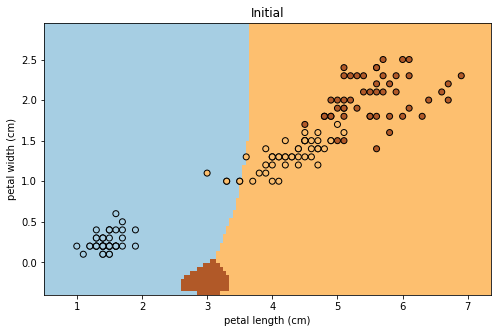

In [41]:
# パラメータthetaの初期値のもとでのグラフ
decision_boundary(x_train, iris.target, theta_init, title='Initial')

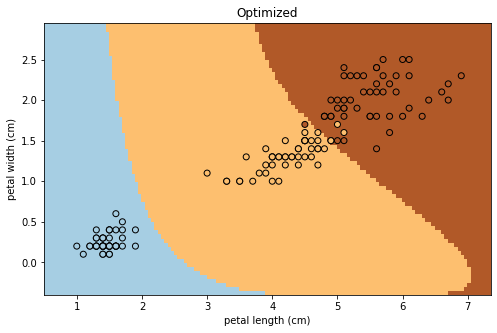

In [42]:
# パラメータthetaの最適解のもとでのグラフ
decision_boundary(x_train, iris.target, theta_opt, title='Optimized')

上図、下図がそれぞれ学習前、学習後に対応している。ここで、データ点と各メッシュの色は、それぞれ同じ品種に対応している。  
確かにIrisデータセットの分類に成功していることがわかる。

### まとめ

本節では、量子回路学習(QCL)を用いて実際の機械学習の問題（分類問題）の解決を行った。  
以上は簡単な例ではあるが、量子コンピュータの機械学習への応用の可能性を示唆している。  
意欲のある読者は、QCLを用いてより高度な機械学習のタスク（画像認識、自然言語処理など）や、上記モデルの改善に挑戦されたい。  
また、更に深く勉強されたい向きは、株式会社QunaSys 御手洗による、量子機械学習に関する[講義ノート](https://www2.yukawa.kyoto-u.ac.jp/~qischool2019/mitaraiCTO.pdf)を参照されたい。